### Introduction

In this assignment, we will build an end to end machine learning pipeline to predict if S&P 500 is likely to move up or down. But first of all, what is S&P500? S&P500 or simply S&P is a "stock market index". A stock market index is designed to replicate the performance of the entire stock market. S&P500, consists of 500 large companies listed on stock exchanges in US; and it is the most commonly followed index globally. You can read more about S&P500 [on this link](https://www.thebalance.com/what-is-the-sandp-500-3305888).

In [1]:
import yfinance as yf #getting the latest data from Yahoo Finance
from matplotlib import pyplot as plt # for visualization
from datetime import datetime, timedelta # handle datetime
import pandas as pd
import numpy as np
import json
from pprint import pprint
# machine learning with sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import _pickle as cPickle # save ML model
from google.cloud import storage # save the model to GCS

### Data Explanation

In [2]:
# data path
raw_data_path = "gs://mlops-stock-prediction/raw/"
feature_data_path = "gs://mlops-stock-prediction/feature_store/"
model_path = "model_repository/"
tmp_dir = '/tmp/'
# download data
sp500_df = yf.download('^GSPC', progress=False)
# persist data
sp500_df.to_parquet(raw_data_path + 'sp500.parquet', compression='GZIP')

In [3]:
# let's just explore the data a little bit
sp500_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


In [4]:
# also let's just check for missing data
sp500_df[sp500_df['Open']==0].sum()

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

As we can see from the data above, we have the following information:
* **Open**      : Price for the opening or start of the day
* **High**      : Highest price for that day
* **Low**       : Lowest price for that day
* **Close**     : Closing price
* **Adj Close** : closing price after adjustments for all applicable splits and dividend distributions.
* **Volume**    : Numbers of shares exchanging hands that day (buying & selling)


## Feature Engineering

Our ambition is to predict the closing price of the S&P500 for a given date. However, we only have a few features in our data; and machine learning model typically leverages large feature sets and picks the best features for solving the problem. So in this section, we will create more features from our data.

In [5]:
# create empty df to store feature
sp500_feautres_df = pd.DataFrame()

In [6]:
# price for window of different days
average_days_window_closing_price = [5, 30, 120, 365]
for window in average_days_window_closing_price:
    sp500_feautres_df['Close__rolling_mean__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).mean().shift(periods=1)
    sp500_feautres_df['Close__rolling_std__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).std().shift(periods=1)
    sp500_feautres_df['Close__rolling_max__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).max().shift(periods=1)
    sp500_feautres_df['Close__rolling_min__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).min().shift(periods=1)
    sp500_feautres_df['Close__rolling_range__'+str(window)+'_days'] = sp500_feautres_df['Close__rolling_max__'+str(window)+'_days'] - sp500_feautres_df['Close__rolling_min__'+str(window)+'_days']

In [7]:
# volume for window of different days
average_days_window_volume = [5, 10, 15]
for window in average_days_window_volume:
    sp500_feautres_df['Volume__rolling_max__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).max().shift(periods=1)
    sp500_feautres_df['Volume__rolling_sum__'+str(window)+'_days'] = sp500_df['Close'].rolling(window).sum().shift(periods=1)

#### Seasonality

In [8]:
# get day of the week
sp500_df['day_of_week'] = sp500_df.index.dayofweek
# get quarter
sp500_df['quarter'] = sp500_df.index.quarter

In [9]:
sp500_feautres_df = pd.concat([sp500_feautres_df, pd.get_dummies(sp500_df['day_of_week'], prefix='day_of_week')], 1)
sp500_feautres_df = pd.concat([sp500_feautres_df, pd.get_dummies(sp500_df['day_of_week'], prefix='quarter')], 1)

### Train Random Forest

In [10]:
# let's not confuse our model from data from way back
sp500_feautres_df = sp500_feautres_df[sp500_feautres_df.index > datetime(year=1990, month=12, day=31)]
# get label for feature dataset
sp500_final_df = pd.merge(sp500_df['Close'], sp500_feautres_df, left_index=True, right_index=True)
# write out to parquet
sp500_final_df.to_parquet(feature_data_path + 'sp500_features.parquet', compression='GZIP')

In [11]:
# hold out last months data for evaluation
sp500_last_month_df = sp500_final_df[sp500_feautres_df.index > (datetime.today() - timedelta(days=30))]
# this will be our training set
sp500_train_df = sp500_final_df[sp500_feautres_df.index < (datetime.today() - timedelta(days=30))]

In [12]:
# get x and y
x_train, y_train = sp500_train_df.drop('Close', axis=1), sp500_train_df['Close']

In [13]:
rf_non_opt = RandomForestRegressor()
rf_non_opt.fit(x_train, y_train)

RandomForestRegressor()

In [14]:
# Number of trees in random forest
n_estimators = [150, 250, 300, 400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 50, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [1, 2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [15]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train) # since we will use CV, we don't need to split data to train and test

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 50, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 5, 10],
                                        'n_estimators': [150, 250, 300, 400]},
                   random_state=42, verbose=2)

In [17]:
# save the best paramas
with open('best_param.json', 'w') as outfile:
    json.dump(rf_random.best_params_, outfile)

In [18]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}


### Evaluating The Two Models

In [19]:
x_lm, y_lm = sp500_last_month_df.drop('Close', axis=1), sp500_last_month_df['Close']

In [20]:
predictions_lm_non_opt = rf_non_opt.predict(x_lm)
predictions_lm_random = rf_random.predict(x_lm)
print('mean absolute error without optimization: %s' % mean_absolute_error(y_lm, predictions_lm_non_opt))
print('mean absolute error with optimization: %s' % mean_absolute_error(y_lm, predictions_lm_random))
print('mean squared error without optimization is: %s' % mean_squared_error(y_lm, predictions_lm_non_opt)) 
print('mean squared error with optimization is: %s' % mean_squared_error(y_lm, predictions_lm_random)) 

mean absolute error without optimization: 96.78708773526277
mean absolute error with optimization: 93.25790131174614
mean squared error without optimization is: 14851.029731834242
mean squared error with optimization is: 12682.66448552982


In [21]:
val_df = pd.DataFrame(list(zip(y_lm, predictions_lm_non_opt, predictions_lm_random)))
val_df.columns = ['Actual', 'Non Optimized RF', 'Optimized RF']

In [22]:
val_df.index = sp500_last_month_df.index

Text(0.5, 1.0, 'Optimized Random Forest')

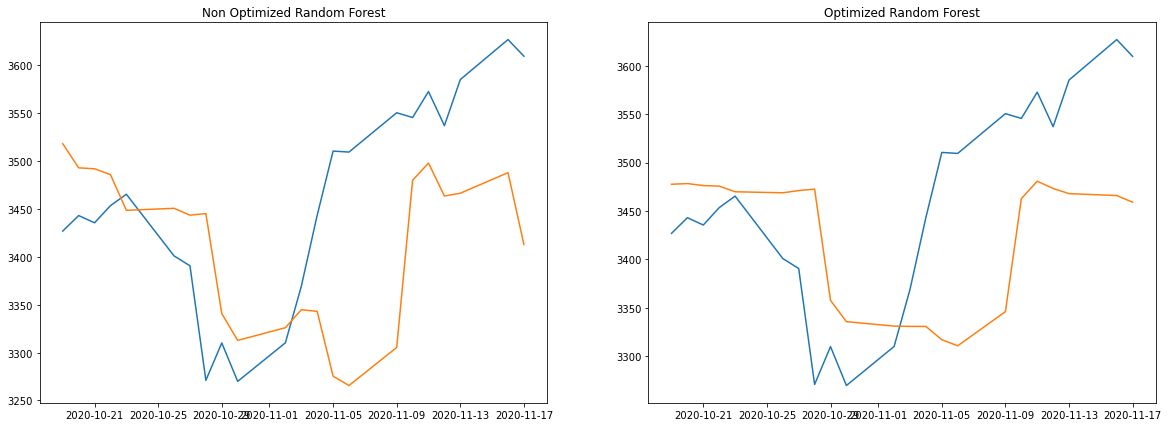

In [23]:
fig, axs = plt.subplots(1,2, figsize=(20, 7))
axs[0].plot(val_df[['Actual', 'Non Optimized RF']])
axs[0].set_title('Non Optimized Random Forest')
axs[1].plot(val_df[['Actual', 'Optimized RF']])
axs[1].set_title('Optimized Random Forest')

### Save The Model

In [24]:
# take the model with the best score
if mean_absolute_error(y_lm, predictions_lm_random) < mean_absolute_error(y_lm, predictions_lm_non_opt):
    rf_best = rf_random.best_estimator_
    print('taking the optimized version')
else:
    rf_best = rf_non_opt
    print('taking the non-optimized version')

taking the optimized version


In [25]:
# save the model into temp
with open('/tmp/model.pickle', 'wb') as f:
    cPickle.dump(rf_best, f, -1)

In [26]:
# get client and write to GCS
client = storage.Client()
bucket = client.get_bucket('mlops-stock-prediction')
blob = bucket.blob(model_path+'model.pickle')
blob.upload_from_filename('/tmp/model.pickle')